**Project name:“Intelligent Identification of Knee Osteoarthritis Severity Using Deep Learning”**

Name: Viralben Raval(student ID:Q15826589 )

Detasetsource: https://www.kaggle.com/datasets/shashwatwork/kneeosteoarthritis-dataset-with-severity?select=train 
     


Importing necessary library


In [ ]:
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import cv2
import glob
import tensorflow as tf

 
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input 


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input

### Define the folder paths and mount drive

In [ ]:
base_dir = "/content/drive/My Drive/Kneeoa"

train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Plotting some sample images from each of the classes

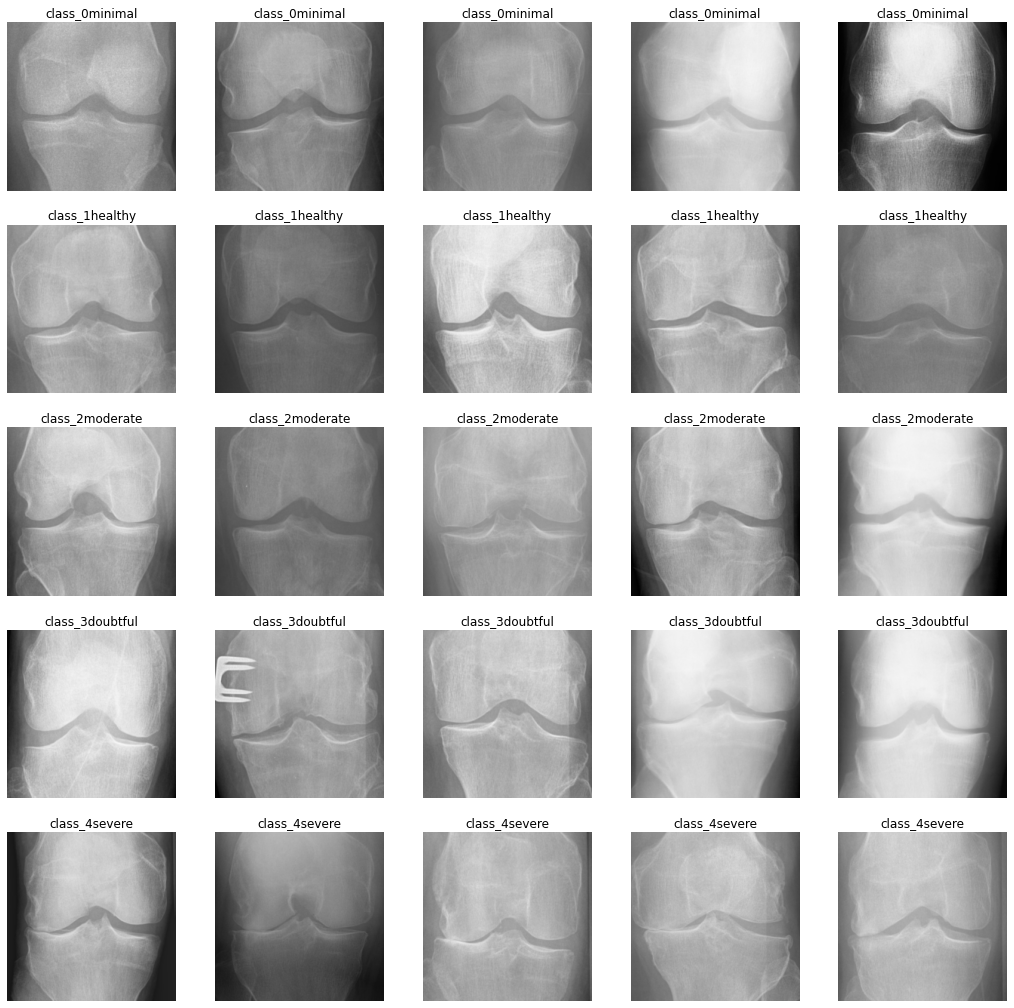

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(18,18))

for class_id in range(5):
    folder = os.path.join(train_dir,str(class_id))
    os.chdir(folder)
    samples = random.sample(os.listdir(folder), 5)
    
    if class_id == 0:
      mystr1 = 'minimal'
    elif class_id == 1:
      mystr1 = 'healthy'
    elif class_id == 2:
      mystr1 = 'moderate'
    elif class_id == 3:
      mystr1 = 'doubtful'
    else :
      mystr1 = 'severe'
    for col in range(5):
        image = cv2.imread(samples[col])
        ax[class_id, col].imshow(image)
        ax[class_id, col].set_title("class_" + str(class_id)+mystr1)
        ax[class_id, col].set_axis_off()

   

### Checking the distribution for train, test and validation

In [ ]:
def show_distribution(folder):
    
    
    x11 = []
    x12 = []
    
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(folder)

    counter = Counter(generator.classes)                          
    total_images = sum(counter.values())
    distribution = [(class_id,round(num_images / total_images * 100,2)) for class_id, num_images in counter.items()]
  
    for class_id, percentage in distribution:

      print(class_id, percentage)
      x11.append(percentage)
      class_id.astype(str)
      type(class_id)
      class_id1 = 'Class_' + class_id.astype(str)
      x12.append(class_id1)

    print(x11)
    plt.pie(x11, labels = x12)    
      


The distribution for the training data is :

Found 5778 images belonging to 5 classes.
0 39.56
1 18.1
2 26.24
3 13.1
4 2.99
[39.56, 18.1, 26.24, 13.1, 2.99]


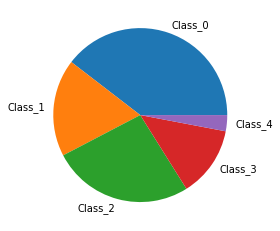

In [ ]:
print("The distribution for the training data is :\n")
show_distribution(train_dir)

The distribution for the validation data is :

Found 826 images belonging to 5 classes.
0 39.71
1 18.52
2 25.67
3 12.83
4 3.27
[39.71, 18.52, 25.67, 12.83, 3.27]


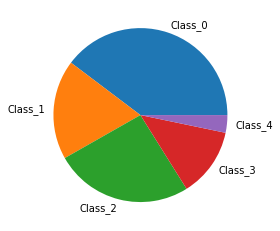

In [ ]:
print("The distribution for the validation data is :\n")
show_distribution(val_dir)

The distribution for the test data is :

Found 1659 images belonging to 5 classes.
0 38.52
1 18.02
2 26.94
3 13.44
4 3.07
[38.52, 18.02, 26.94, 13.44, 3.07]


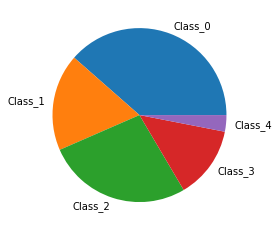

In [ ]:
print("The distribution for the test data is :\n")
show_distribution(test_dir)

Checking the correlation

In [ ]:
#check data correlation
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(5, 5))
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

Ploting the Heatmap

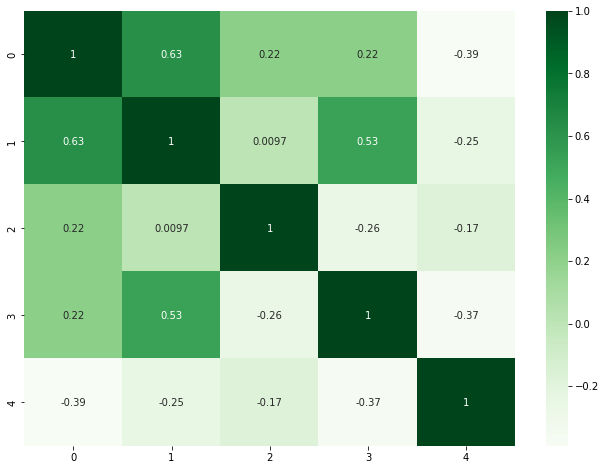

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(18, 18))
df= df.iloc[: , [0,1,2,3,4]].copy()
corr = df.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

Define the weights

In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_dir)
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
print("\nThe class weights are : \n\n", class_weights)

Found 5778 images belonging to 5 classes.

The class weights are : 

 {0: 1.0, 1: 2.18546845124283, 2: 1.507915567282322, 3: 3.0198150594451785, 4: 13.213872832369942}


### Overcoming dis-balanced classes
#### Trying to fix imbalanced class distribution in train, val, test sets with weights

### Check the size of the images

In [ ]:
folder = os.path.join(train_dir,'0')
os.chdir(folder)
samples = random.sample(os.listdir(folder), 5)

for filename in samples:
    image = cv2.imread(filename)
    print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


## Build the model

In [ ]:
NUM_CLASSES = 5
IMAGE_SIZE=[224, 224]
BATCH_SIZE=64

In [ ]:
# Create the Generators
train_val_generator = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,    
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest'
                                        )


# Train data generator
train_data = train_val_generator.flow_from_directory(train_dir, 
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True
                                                    )

# Validation data generator
val_data = train_val_generator.flow_from_directory(val_dir, 
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  shuffle=True
                                                  )

# Test data generator
test_generator  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_generator.flow_from_directory(test_dir, 
                                               target_size=IMAGE_SIZE,
                                               batch_size=1,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False
                                               )

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1659 images belonging to 5 classes.


In [ ]:
type(test_data)

keras.preprocessing.image.DirectoryIterator

### Adding reducelronplateau & early stopping

In [ ]:
# Viral's changes 1 : neat and clean result
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)                       # for better learnig it should be 0.001
# early_stopping = EarlyStopping(monitor = 'loss', patience = 3)


 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor = 'loss', patience = 5)

### By using inception v3 - FINE TUNED

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 5 classes
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_data,
         validation_data = val_data,
          epochs = 100,
          callbacks = [reduce_lr, early_stopping]
          )

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use adam optimizer

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(train_data,
         validation_data = val_data,
         epochs = 100,
         callbacks = [reduce_lr, early_stopping]
         )


87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/100
91/91 [==============================] - 1896s 21s/step - loss: 1.8085 - accuracy: 0.3840 - val_loss: 1.3231 - val_accuracy: 0.4322 - lr: 0.0010
Epoch 2/100
91/91 [==============================] - 83s 911ms/step - loss: 1.2728 - accuracy: 0.4540 - val_loss: 1.4005 - val_accuracy: 0.4298 - lr: 0.0010
Epoch 3/100
91/91 [==============================] - 83s 906ms/step - loss: 1.2618 - accuracy: 0.4635 - val_loss: 1.2732 - val_accuracy: 0.4492 - lr: 0.0010
Epoch 4/100
91/91 [==============================] - 82s 905ms/step - loss: 1.2409 - accuracy: 0.4616 - val_loss: 1.2663 - val_accuracy: 0.4455 - lr: 0.0010
Epoch 5/100
91/91 [==============================] - 81s 894ms/step - loss: 1.2242 - accuracy: 0.4688 - val_loss: 1.2220 - val_accuracy: 0.4528 - lr: 0.0010
Epoch 6/100
91/91 [==============================] - 81s 892ms/step - loss: 1.2016 - accuracy: 0.4851 - val_loss: 1.2134 - val_accuracy: 0.4782 - lr: 

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(model,show_shapes= true)
img_file = './model_arch.png'

tf.keras.utils.plot_model(model, show_shapes=True)
    

### Scores for inceptionv3

In [ ]:
# model accuracy on train dataset
score = model.evaluate(train_data,
                       verbose=0)
print("\nTrain accuracy: %.1f%%" % (100.0 * score[1]))


Train accuracy: 86.2%


In [ ]:
# model accuracy on test dataset
score = model.evaluate(val_data,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 50.2%


In [ ]:
eval_score = model.evaluate(val_data)
print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

13/13 [==============================] - 10s 751ms/step - loss: 1.7084 - accuracy: 0.4794
Test loss: 1.7083715200424194
Test accuracy: 0.47941887378692627


### Graphs

### Training validation loss vs Training validation accuracy

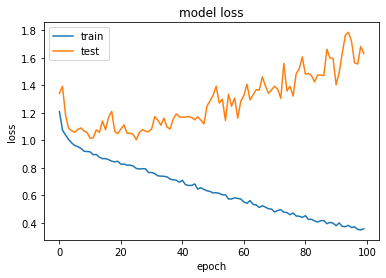

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

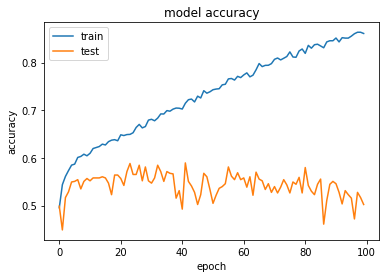

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Ploting the graph of training & validation loss and accuracy

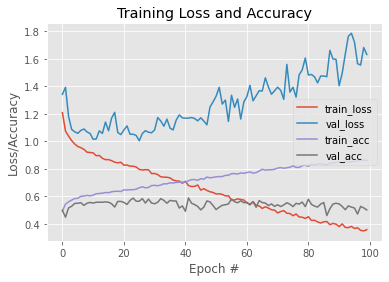

In [ ]:
from matplotlib import pyplot as plt
# plot the training loss and accuracy
N = 100 #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("Inception_v3_Model")


Confusion matrix of Inception_v3 model

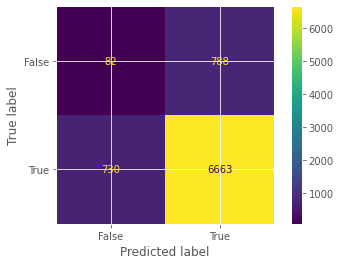

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size =8263 )
predicted = numpy.random.binomial(1,.9,size =8263 )

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Confusion Matrix : 
 [[  82  788]
 [ 730 6663]]


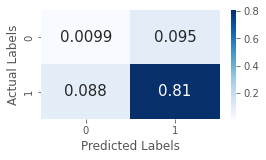

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

matrix = confusion_matrix(actual, predicted)
print('Confusion Matrix : \n', matrix)

plt.subplots(figsize = (4,2))
cmap = sns.diverging_palette(250,10, s=80, l=55, n=9, as_cmap=True)

sns.heatmap(matrix/np.sum(matrix), cmap='Blues', annot = True, annot_kws = {'size': 15})
plt.xlabel('Predicted Labels', fontsize = 12)
plt.ylabel('Actual Labels', fontsize = 12)
#plt.title(f'Confusion matrix for Inception model : {name}\n', fontsize = 15)
plt.show()

Classification Report of Inception_v3 model

In [ ]:
 from sklearn.metrics import classification_report 
 print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.10      0.09      0.10       870
           1       0.89      0.90      0.90      7393

    accuracy                           0.82      8263
   macro avg       0.50      0.50      0.50      8263
weighted avg       0.81      0.82      0.81      8263



 Plot the training and validation Loss VS Accuracy

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=50, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=50, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

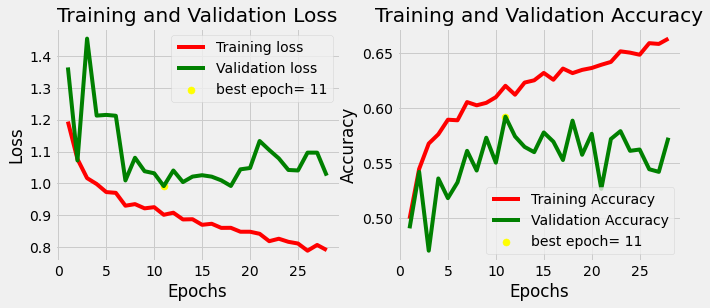

In [ ]:
tr_plot(history, 0)  # plot the loss and accuracy metrics

### By Using Xception - FINE TUNED**(Xception model)**

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 5 classes
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_data,
         validation_data = val_data,
          epochs = 100,
          #callbacks = [reduce_lr, early_stopping]
          )

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from Xception. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 Xception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use adam optimizer

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# we train our model again (this time fine-tuning the top 2 Xception blocks
# alongside the top Dense layers
history = model.fit(train_data,
         validation_data = val_data,
         epochs = 100,
         #callbacks = [reduce_lr, early_stopping]
         )

# model.predict(test_data[: , 0], batch_size = 64)

Epoch 1/100
91/91 [==============================] - 89s 948ms/step - loss: 1.3961 - accuracy: 0.4140 - val_loss: 1.2658 - val_accuracy: 0.4492
Epoch 2/100
91/91 [==============================] - 85s 932ms/step - loss: 1.2421 - accuracy: 0.4668 - val_loss: 1.2411 - val_accuracy: 0.4588
Epoch 3/100
91/91 [==============================] - 85s 929ms/step - loss: 1.2123 - accuracy: 0.4688 - val_loss: 1.2465 - val_accuracy: 0.4528
Epoch 4/100
91/91 [==============================] - 85s 932ms/step - loss: 1.1998 - accuracy: 0.4844 - val_loss: 1.2180 - val_accuracy: 0.4758
Epoch 5/100
91/91 [==============================] - 84s 923ms/step - loss: 1.1824 - accuracy: 0.4978 - val_loss: 1.3013 - val_accuracy: 0.4540
Epoch 6/100
91/91 [==============================] - 84s 927ms/step - loss: 1.1955 - accuracy: 0.4874 - val_loss: 1.2293 - val_accuracy: 0.4625
Epoch 7/100
91/91 [==============================] - 84s 926ms/step - loss: 1.1698 - accuracy: 0.5022 - val_loss: 1.1966 - val_accuracy:

### Scores for xception

In [ ]:
# model accuracy on train dataset
score = model.evaluate(train_data,
                       verbose=0)
print("\nTrain accuracy: %.1f%%" % (100.0 * score[1]))


Train accuracy: 56.0%


In [ ]:
# model accuracy on test dataset
score = model.evaluate(val_data,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 47.8%


In [ ]:
eval_score = model.evaluate(val_data)
print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

13/13 [==============================] - 11s 799ms/step - loss: 1.1856 - accuracy: 0.4927
Test loss: 1.1856478452682495
Test accuracy: 0.4927360713481903


### Graphs

### Training validation loss vs Training validation accuracy

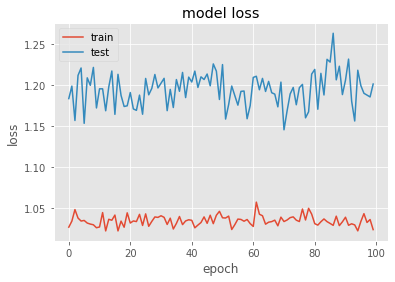

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

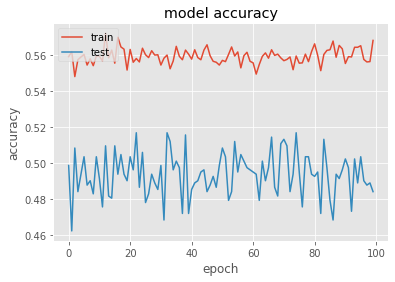

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Graphs of Training Loss and accuracy

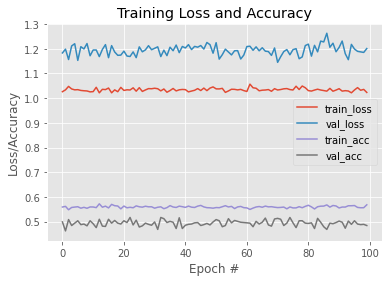

In [ ]:
from matplotlib import pyplot as plt
# plot the training loss and accuracy
N = 100 #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("Xceotion_Model")

Confusion Matrix of Exeption Model

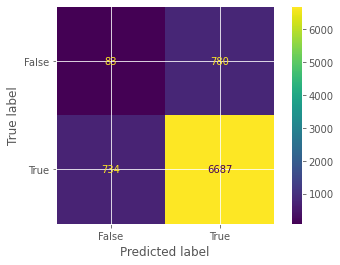

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 8284)
predicted = numpy.random.binomial(1,.9,size = 8284)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Plot the training and validation data Loss VS Accuracy


In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=100, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=100, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

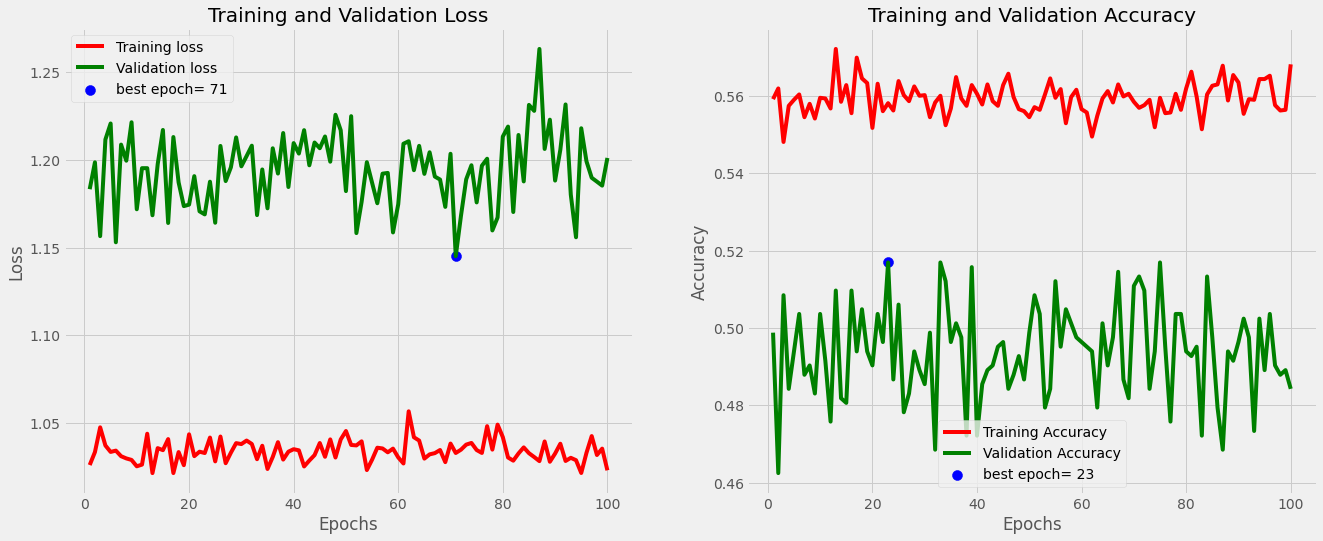

In [ ]:
tr_plot(history, 0)  # plot the loss and accuracy metrics

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import confusion_matrix


Confusion Matrix of Xception Model

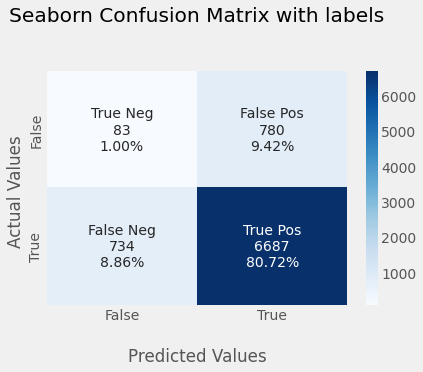

In [ ]:

from sklearn.metrics import confusion_matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()









 





Classification Report of Xception Model

In [ ]:
from sklearn.metrics import classification_report 
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10       863
           1       0.90      0.90      0.90      7421

    accuracy                           0.82      8284
   macro avg       0.50      0.50      0.50      8284
weighted avg       0.81      0.82      0.82      8284

